### **Bayesian SIR Model**

The Bayesian SIR (Susceptible-Infected-Removed) model with change points is an advanced epidemiological model designed to analyze and predict the spread of infectious diseases, such as COVID-19, while accounting for significant changes in transmission dynamics over time. This model incorporates Bayesian inference and change point detection to adapt to varying transmission and removal rates, providing a more flexible and accurate depiction of disease spread compared to traditional SIR models.

#### Key Components and Concepts

1. **SIR Model:**
   The standard SIR model divides a population into three compartments:
   - **Susceptible (S):** Individuals who can contract the disease.
   - **Infected (I):** Individuals who have contracted the disease and can spread it.
   - **Removed (R):** Individuals who have either recovered from the disease or died, and are no longer infectious.

   Each individual is assumed to be in one state at ant time.

   Assuming that in-person contacts among individuals follow the Erdos-Renyi model,
   The model is governed by a set of ordinary differential equations (ODEs) that describe the flow of individuals between these compartments:


   $$
   \frac{dS(t)}{dt} = -\beta S(t) I(t)/N
   $$
   $$
   \frac{dI(t)}{dt} = \beta S(t) I(t)/N - \gamma I(t)
   $$
   $$
   \frac{dR(t)}{dt} = \gamma I(t)
   $$
    
 where:
   - β is the transmission rate.
   - γ is the removal rate.
   - \( N \) is the total population size.

$$
   \frac{dS(t)}{dt} + \frac{dI(t)}{dt} + \frac{dR(t)}{dt} = 0,
$$   

For t>= 0,  the population size is fixed as

$$ S(t) + I(t) + R(t) = N
$$

2. **Change Points:**
   In real-world scenarios, factors such as government interventions, behavioral changes, and seasonal effects can cause abrupt changes in the transmission and removal rates. The Bayesian SIR model with change points introduces a mechanism to detect these changes and adjust the model parameters accordingly.

3. **Bayesian Inference:**
   Bayesian inference is used to estimate the parameters of the model (e.g., transmission and removal rates) by updating the probability distributions of these parameters based on observed data. This approach allows for the incorporation of prior knowledge and the quantification of uncertainty in the parameter estimates.

4. **Markov Chain Monte Carlo (MCMC) Algorithm:**
   An MCMC algorithm is developed to sample from the posterior distributions of the model parameters. This algorithm iteratively updates the parameters based on the observed data, providing a comprehensive set of posterior samples that can be used for inference and prediction.

5. **Stochastic SIR Model:**
   The stochastic version of the SIR model accounts for randomness in the infection and removal processes. This model assumes that the numbers of newly infected and removed individuals follow binomial distributions:
   
   $$
   \Delta I_t \sim \text{Binomial}(S_{t-1}, 1 - \exp(-\beta_t I_{t-1}/N))
   $$
   $$
   \Delta R_t \sim \text{Binomial}(I_{t-1}, \gamma_t)
   $$

 $$
  S_t = S_{t-1} - \Delta I_t
  $$
  $$
  I_t = I_{t-1} + \Delta I_t - \Delta R_t
  $$
  $$
  R_t = R_{t-1} + \Delta R_t
  $$
  
where

$$P_t = I_t/N$$ : the proportion of infectious individuals at day t

$$S_t, I_t, R_t$$ : updated as in Figure 1

Time-varying parameters "beta_t in (0, infty)"  and "gamma_t in (0, 1)" represent the transmission rate and the removal rate at day  t , respectively.

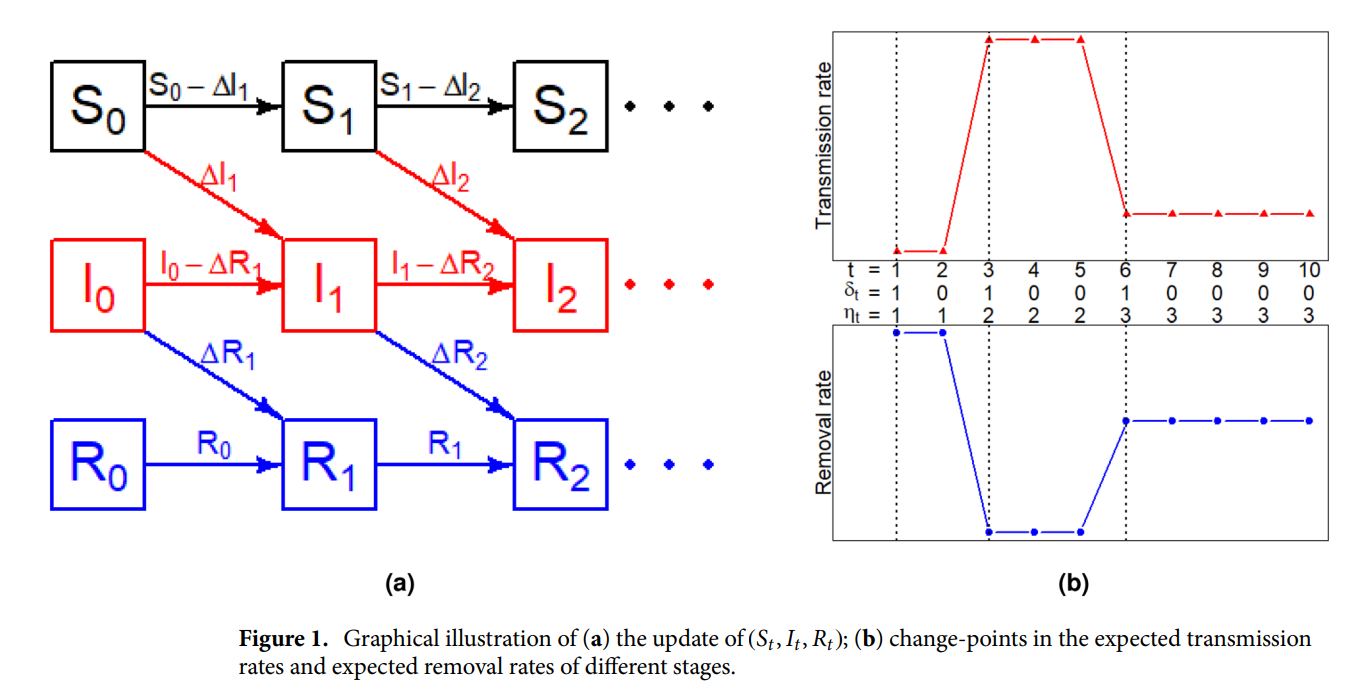



Import necessary Python packages

In [ ]:
import numpy as np
from scipy.stats import expon, poisson
from scipy.stats import gamma as gamma_stat
from scipy.stats import beta as beta_stat
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import loggamma
import tqdm
from itertools import combinations

## Make the simulated data

Here we have simulated the data we need instead of using a real world data set.

The function created simulates the spread of an infectious disease using a modified SIR (Susceptible-Infected-Removed) model. It generates synthetic data for the number of susceptible, infected, and removed individuals over a specified period (T_max). The function also incorporates change points where the transmission and removal rates may vary.

**Parameters:**

beta_model: An array representing the model transmission rates for different stages.

gamma_model: An array representing the model removal rates for different stages.

N: The total population size.

T_max: The total number of days for the simulation.

**With initial numbers (S0, I0, R0) = (N − 50, 50, 0) , we generate 100 datasets for each of three scenarios. Within
each dataset, daily confirmed cases  I and daily removed cases  R are generated sequentially.**

In [ ]:
 def create_data(beta_model,gamma_model, N, T_max):

  Delta = np.tile(np.concatenate(([1], np.repeat(0, 24))), 4)
  Stage = np.cumsum(Delta)
  K = np.sum(Delta)

  b = 1 / beta_model
  r = 1 / (1-gamma_model) - 1

  beta = 1 / b[Stage.astype(int)-1]
  gamma = r[Stage.astype(int)-1] / (1 + r[Stage.astype(int)-1])

  I_current = 50
  R_current = 0
  S_current = N - I_current - R_current

  N_infect_obs = [I_current]
  N_recovery_obs = [R_current]

  for t in range(1, T_max + 1):
      PI_current = I_current / N
      p_beta = 1 - np.exp(-beta[t - 1] * PI_current)
      New_infect = np.random.binomial(S_current, p_beta, size=1)[0]
      New_recovery = np.random.binomial(I_current, gamma[t - 1], size=1)[0]

      N_infect_obs.append(New_infect)
      N_recovery_obs.append(New_recovery)
      S_current -= New_infect
      I_current -= New_recovery - New_infect
      R_current += New_recovery
      # print(S_current)
  S_obs = N - np.cumsum(N_infect_obs)
  I_obs = np.cumsum(np.array(N_infect_obs) - np.array(N_recovery_obs))
  R_obs = np.cumsum(N_recovery_obs)
  PI_obs = I_obs / N
  N_infect_obs = N_infect_obs[1:]
  N_recovery_obs = N_recovery_obs[1:]

  data_df = pd.DataFrame({
    'S_obs': S_obs,
    'I_obs': I_obs,
    'R_obs': R_obs,
    'PI_obs': PI_obs,
    'N_infect_obs': np.append(N_infect_obs, [np.nan]),  # Append NaN for missing value at the end
    'N_recovery_obs': np.append(N_recovery_obs, [np.nan])  # Append NaN for missing value at the end
})

  return data_df, beta, gamma


In this part ,we have set the population size (`N`)  to 1,000,000 and the simulation duration (`T_max`) is set to 100 days.

The parameters for the Bayesian SIR model with change points are defined for three different scenarios, each with distinct transmission (`beta_model`) and removal (`gamma_model`) rates.

Scenario 1 :
$$
(\beta_t, \gamma_t) =
\begin{cases}
(0.3, 0.05), & \text{for } t = 1, \ldots, 25 \\
(0.4, 0.15), & \text{for } t = 26, \ldots, 50 \\
(0.25, 0.2), & \text{for } t = 51, \ldots, 75 \\
(0.2, 0.25), & \text{for } t = 76, \ldots, 100
\end{cases}
$$

Scenario 2:
$$
(\beta_t, \gamma_t) =
\begin{cases}
(0.4, 0.1), & \text{for } t = 1, \ldots, 25 \\
(0.4, 0.25), & \text{for } t = 26, \ldots, 50 \\
(0.25, 0.25), & \text{for } t = 51, \ldots, 75 \\
(0.25, 0.4), & \text{for } t = 76, \ldots, 100
\end{cases}
$$

Scenario 3:
$$
(\beta_t, \gamma_t) =
\begin{cases}
(0.5, 0.1), & \text{for } t = 1, \ldots, 25 \\
(0.3, 0.3), & \text{for } t = 26, \ldots, 50 \\
(0.4, 0.2), & \text{for } t = 51, \ldots, 75 \\
(0.2, 0.4), & \text{for } t = 76, \ldots, 100
\end{cases}
$$


In [ ]:
N = 1000000
T_max = 100

## SCENARIO 1
beta_model = np.array([0.3, 0.4, 0.25, 0.2])
gamma_model = np.array([0.05, 0.15, 0.2, 0.25])

## SCENARIO 2
# beta_model = np.array([0.4, 0.4, 0.25, 0.25])
# gamma_model = np.array([0.1, 0.25, 0.25, 0.4])

## SCENARIO 3
# beta_model = np.array([0.5, 0.3, 0.4, 0.2])
# gamma_model = np.array([0.1, 0.3, 0.2, 0.4])

data_atf, beta_mod_t, gamma_mod_t = create_data(beta_model, gamma_model, N, T_max)

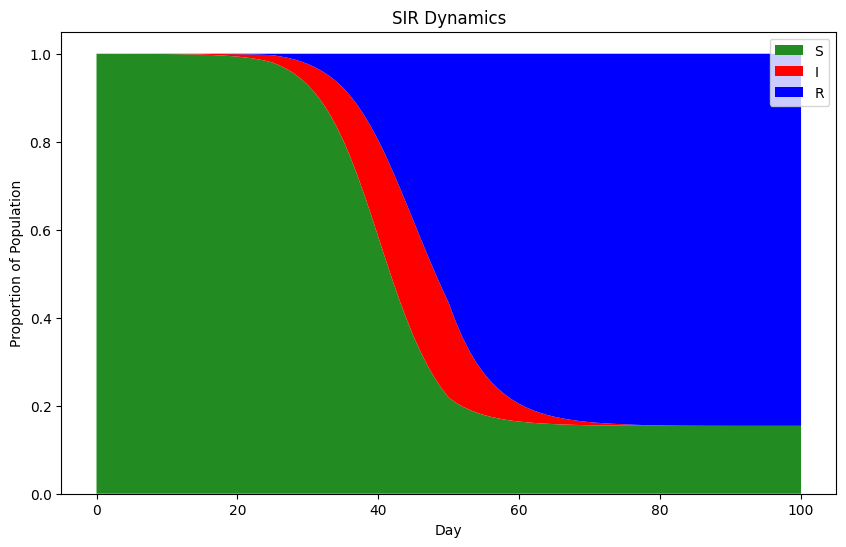

In [ ]:
# Plotting
plotting = True
if plotting == True:
  days = np.arange(T_max + 1)
  plt.figure(figsize=(10, 6))
  plt.stackplot(days, data_atf['S_obs']/N, data_atf['I_obs']/N, data_atf['R_obs']/N, labels=['S', 'I', 'R'], colors=['forestgreen', 'red', 'blue'])
  plt.title('SIR Dynamics')
  plt.xlabel('Day')
  plt.ylabel('Proportion of Population')
  plt.legend(loc='upper right')
  plt.show()

Below functions initializes the parameters for the Bayesian SIR model with change points.

**update delta**

**Given current values β(g) and γ (g) , δ is updated via an add–delete–swap algorithm. Initializing
δ∗ = δ(g) , an operation is selected from {add, delete, swap} with probabilities.**

$$(p_{\text{add}}, p_{\text{delete}}, p_{\text{swap}}) =
\begin{cases}
(1, 0, 0), & \text{if } K^{(g)} = 1, \\
(0, 1, 0), & \text{if } K^{(g)} = T, \\
\left(\frac{1}{3}, \frac{1}{3}, \frac{1}{3}\right), & \text{otherwise}.
\end{cases}$$

In [ ]:
def candidate_delta(Delta_hat, K_hat, T_max=100):
    # Determine the type of change to make
    change_type = 1 if K_hat == 1 else (-1 if K_hat == T_max else np.random.choice([-1, 0, 1]))
    Delta_hat_candidate = Delta_hat.copy()

    # If change_type is swap (0)
    if change_type == 0:
        # Identify indices that are 0 and followed by a 1
        possible_swap_indices = np.where((Delta_hat[1:-1] == 1) & (Delta_hat[2:] == 0))[0] + 1
        if possible_swap_indices.size > 0:
            index_to_swap = np.random.choice(possible_swap_indices)
            # Swap the 0 with the 1 it precedes
            Delta_hat_candidate[index_to_swap], Delta_hat_candidate[index_to_swap + 1] = Delta_hat_candidate[index_to_swap + 1], Delta_hat_candidate[index_to_swap]

    # If change_type is addition (1)
    if change_type == 1:
        possible_change_indices = np.where(Delta_hat[1:T_max] == 0)[0] + 1
        if len(possible_change_indices) > 0:
            index_to_change = np.random.choice(possible_change_indices)
            Delta_hat_candidate[index_to_change] = 1

    # If change_type is deletion (-1)
    if change_type == -1:
        possible_change_indices = np.where(Delta_hat[1:T_max] == 1)[0] + 1
        if len(possible_change_indices) > 0:
            index_to_change = np.random.choice(possible_change_indices)
            Delta_hat_candidate[index_to_change] = 0

    # Calculate the new stages and number of 1s
    Stage_hat_candidate = np.cumsum(Delta_hat_candidate)
    K_hat_candidate = np.sum(Delta_hat_candidate)

    return Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate


$$\frac{\pi(\delta^*)}{\pi(\delta^{(g)})} =
\frac{p^{\sum_{t=1}^{T} \delta^*_t} (1 - p)^{T - \sum_{t=1}^{T} \delta^*_t}}{p^{\sum_{t=1}^{T} \delta^{(g)}_t} (1 - p)^{T - \sum_{t=1}^{T} \delta^{(g)}_t}}
= \left( \frac{p}{1 - p} \right)^{\sum_{t=1}^{T} (\delta^*_t - \delta^{(g)}_t)}$$

In [ ]:
def calculate_log_prior_ratio(K_hat_candidate, K_hat, p=0.01):
    return (K_hat_candidate - K_hat) * np.log(p / (1 - p))

$\frac{\left( J(\delta^{(g)} \mid \delta^*) \right)} {\left( J(\delta^* \mid \delta^{(g))} \right)) } =
\begin{cases}
1, & \text{if } \sum_{t=1}^{T} \delta^*_t = \sum_{t=1}^{T} \delta^{(g)}_t, \\
\frac{3}{T - 1}, & \text{if } (\sum_{t=1}^{T} \delta^*_t, \sum_{t=1}^{T} \delta^{(g)}_t) = (1, 2) \text{ or } (T, T - 1), \\
\frac{T - 1}{3}, & \text{if } (\sum_{t=1}^{T} \delta^*_t, \sum_{t=1}^{T} \delta^{(g)}_t) = (2, 1) \text{ or } (T - 1, T), \\
\frac{\sum_{t=1}^{T} \delta^{(g)}_t - 1}{T - \sum_{t=1}^{T} \delta^*_t}, & \text{if } (\sum_{t=1}^{T} \delta^*_t, \sum_{t=1}^{T} \delta^{(g)}_t) \in \{(2, 3), (3, 4), \ldots, (T - 2, T - 1)\}, \\
\frac{T - \sum_{t=1}^{T} \delta^{(g)}_t}{\sum_{t=1}^{T} \delta^*_t - 1}, & \text{if } (\sum_{t=1}^{T} \delta^*_t, \sum_{t=1}^{T} \delta^{(g)}_t) \in \{(3, 2), (4, 3), \ldots, (T - 1, T - 2)\}.
\end{cases}$


In [ ]:
def calculate_log_jump_ratio(K_hat_candidate, K_hat, T_max=100):
    if K_hat == K_hat_candidate:
        return 0
    elif ([K_hat_candidate, K_hat] == [1, 2] or [K_hat_candidate, K_hat] == [T_max, T_max-1]):
        return np.log(3 / (T_max - 1))
    elif ([K_hat_candidate, K_hat] == [2, 1] or [K_hat_candidate, K_hat] == [T_max-1, T_max]):
        return np.log((T_max - 1) / 3)
    elif (K_hat_candidate - K_hat) == -1 and K_hat_candidate != 1 and K_hat_candidate != (T_max-1):
        return np.log((K_hat - 1) / (T_max - K_hat_candidate))
    elif K_hat_candidate - K_hat == 1 and K_hat_candidate != 2 and K_hat_candidate != T_max:
        return np.log((T_max - K_hat) / (K_hat_candidate - 1))

$$
\pi(\beta^{(g)}, \gamma^{(g)} \mid \delta) = \frac{(0.1)^{0.1 \times 2K}}{\Gamma(0.1)^{2K}} \prod_{k=1}^{K} \frac{\Gamma(0.1 + n_k)}{(0.1 + \beta_k)^{(0.1 + n_k)}} \prod_{k=1}^{K} \frac{\Gamma(0.1 + n_k) e^{\gamma_k}}{(0.1 + \gamma_k)^{(0.1 + n_k)}}
$$

$$
= \frac{(0.1)^{0.1 \times 2K}}{\Gamma(0.1)^{2K}}  \prod_{k=1}^{K} e^{-\sum_{t=1}^{T} \mathbb{I}(\eta_t = k) \log \gamma_t^{(g)}} \prod_{k=1}^{K} \frac{\Gamma(0.1 + n_k)}{(0.1 + \beta_k)^{(0.1 + n_k)}} \prod_{k=1}^{K} \frac{\Gamma(0.1 + n_k)}{(0.1 + \gamma_k)^{(0.1 + n_k)}}
$$

The R.H.S. of the equation is divided into multiple parts, in a log format to be:
$$
\log A = K \left(0.2 \log(0.1) - 2 \log \Gamma(0.1)\right)
$$

$$
\log B = \sum_{k=1}^{K} \gamma_k
$$

$$
\log C = \sum_{k=1}^{K} \left( \log \Gamma(0.1 + n_k) - (0.1 + n_k) \log (0.1 + \beta_k) \right)
$$

$$
\log D = \sum_{k=1}^{K} \left( \log \Gamma(0.1 + n_k) - (0.1 + n_k) \log (0.1 + \gamma_k) \right)
$$


In [ ]:
def ll_beta_gamma(delta, beta, gamma_t):
  K = int(np.sum(delta))
  eta = np.cumsum(delta)

  n_k = np.array([np.sum(eta == k) for k in range(1, K + 1)])
  beta_k = np.array([np.sum(beta[eta == k]) for k in range(1, K + 1)])
  # gamma_k = np.array([-np.sum(np.log(gamma[eta == k])) for k in range(1, K + 1)])

  epsilon = 1e-150  # A small number to prevent log(0)
  gamma_k = np.array([-np.sum(np.log(np.maximum(gamma_t[eta == k], epsilon))) for k in range(1, K + 1)])

  # Log components
  logA = (0.2 * np.log(0.1) - 2 * loggamma(0.1)) * K
  logB = np.sum(gamma_k)#-np.sum(np.log(gamma))  # Using all gamma values directly
  logC = np.sum(loggamma(0.1 + n_k) - (0.1 + n_k) * np.log(0.1 + beta_k))
  logD = np.sum(loggamma(0.1 + n_k) - (0.1 + n_k) * np.log(0.1 + gamma_k))

  return logA + logB + logC + logD

In [ ]:
def calculate_log_likelihood_ratio(Delta_hat, Delta_hat_candidate, beta_hat, gamma_hat):
  ratio = ll_beta_gamma(Delta_hat_candidate, beta_hat, gamma_hat) - ll_beta_gamma(Delta_hat, beta_hat, gamma_hat)
  return ratio

In [ ]:
def metropolis_hastings_ratio(log_prior_ratio, log_likelihood_ratio, log_jump_ratio):
    log_mMH = log_prior_ratio + log_likelihood_ratio + log_jump_ratio
    # print(log_likelihood_ratio, log_prior_ratio, log_jump_ratio)
    return np.exp(min(0, log_mMH))

$$\delta^{(g+1)} =
\begin{cases}
\delta^*, & \text{with probability } \min(1, m_{MH}), \\
\delta^{(g)}, & \text{with probability } 1 - \min(1, m_{MH}).
\end{cases}$$


In [ ]:
def sample_delta(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat,p=0.01, T_max=100):

    Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate = candidate_delta(Delta_hat, K_hat, T_max)

    log_prior_ratio = calculate_log_prior_ratio(K_hat_candidate, K_hat, p)
    log_likelihood_ratio = calculate_log_likelihood_ratio(Delta_hat, Delta_hat_candidate, beta_hat, gamma_hat)
    log_jump_ratio = calculate_log_jump_ratio(K_hat_candidate, K_hat, T_max)

    ratio = metropolis_hastings_ratio(log_prior_ratio, log_likelihood_ratio, log_jump_ratio)

    if np.random.binomial(1, ratio) == 1:
        return Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate
    else:
        return Delta_hat, Stage_hat, K_hat

The hierarchical probabilistic model represented by these equations
$$
\beta_t \mid \delta, b \sim \text{Exp}(b_{\eta_t}),
$$

$$
\gamma_t \mid \delta, r \sim \text{Beta}(r_{\eta_t}, 1),
$$

$$
b_1, \ldots, b_K \overset{\text{i.i.d.}}{\sim} \text{Gamma}(0.1, 0.1),
$$

$$
r_1, \ldots, r_K \overset{\text{i.i.d.}}{\sim} \text{Gamma}(0.1, 0.1),
$$

$$
\delta_1, \ldots, \delta_T \overset{\text{i.i.d.}}{\sim} \text{Bernoulli}(p),
$$


### Update b and r:
Given current values $\delta^{(g+1)}$, $\beta^{(g)}$, and $\gamma^{(g)}$, we sample $b_k^{(g+1)}$ and $r_k^{(g+1)}$ from

$$
b_k \sim \text{Gamma} \left( 0.1 + \sum_{t=1}^T \mathbb{I}(\eta_t^{(g+1)} = k), 0.1 + \sum_{t=1}^T \beta_t^{(g)} \mathbb{I}(\eta_t^{(g+1)} = k) \right),
$$

$$
r_k \sim \text{Gamma} \left( 0.1 + \sum_{t=1}^T \mathbb{I}(\eta_t^{(g+1)} = k), 0.1 + \sum_{t=1}^T -\log \gamma_t^{(g)} \mathbb{I}(\eta_t^{(g+1)} = k) \right),
$$

for $k = 1, \ldots, K^{(g+1)}$, where $\mathbb{I}(\cdot)$ is the indicator function and $ K^{(g+1)} = \sum_{t=1}^{T} \delta_{t}^{(g+1)}$

In [ ]:
def update_b_r (delta_new, beta_old, gamma_old):

  #Calculate new K and new Neta
  K_new = int(np.sum(delta_new))
  indices = np.where(delta_new == 1)[0].tolist()
  eta_new = (np.cumsum(delta_new)).astype(int)

  # Initializing array for new b and r
  b_new = np.zeros(K_new)
  r_new = np.zeros(K_new)

  b_new_t = np.array([])
  r_new_t = np.array([])

  epsilon = 1e-150  #Additional small number to avoid error of divide by zero

  for k in range(1,K_new+1):
    indicator_eta = (eta_new == k).astype(int)
    shape_param = 0.1 + np.sum(indicator_eta)

    under_r = 0.1 + np.sum(-np.log(np.maximum(gamma_old, epsilon)) * indicator_eta) #to avoid division by 0 in case of really small gamma
    under_b = 0.1+np.sum(beta_old * indicator_eta)

    scale_r = 1 / under_r #if under_r > epsilon else 1/epsilon
    scale_b = 1 / under_b #if under_b > epsilon else 1/epsilon

    b_new[k-1] = gamma_stat.rvs(shape_param, scale=scale_b)
    r_new[k-1] =  gamma_stat.rvs(shape_param, scale=scale_r)

  # make an array of b for all time step
  b_new_t = b_new[eta_new-1]
  r_new_t = r_new[eta_new-1]

  return b_new, r_new, K_new, eta_new, b_new_t, r_new_t

### Update $\beta$ and $\gamma$:
Given current values $\delta^{(g+1)}$, $b^{(g+1)}$, and $r^{(g+1)}$, we sample $\beta_t^{(g+1)}$ and $\gamma_t^{(g+1)}$ from posterior densities,

$$
\pi(\beta_t \mid S_{t-1}, \Delta I_t, b_{\eta_t^{(g+1)}}^{(g+1)}) \propto \left\{1 - \exp(-\beta_t P_{t-1})\right\}^{\Delta I_t} \exp\left\{-\beta_t P_{t-1}(S_{t-1} - \Delta I_t)\right\} \pi(\beta_t \mid b_{\eta_t^{(g+1)}}^{(g+1)}),
$$

$$
\pi(\gamma_t \mid I_{t-1}, \Delta R_t, r_{\eta_t^{(g+1)}}^{(g+1)}) \propto \gamma_t^{\Delta R_t} (1 - \gamma_t)^{I_{t-1} - \Delta R_t} \pi(\gamma_t \mid r_{\eta_t^{(g+1)}}^{(g+1)}),
$$

for $t = 1, \ldots, T$.

The equations above can be simplify to be:

$\pi(\beta_t) \sim \Gamma \left( \Delta I_t + 1, \; P_{\text{prev}} \cdot (S_{\text{prev}} - \Delta I_t) + b_t \right)$

and

$\pi(\gamma_t) \sim \text{Beta} \left( \Delta R_t + r_t, \; 1 + I_{\text{prev}} - \Delta R_t \right)$




In [ ]:
def update_beta(b, I, S, T=T_max, N=N):

  '''
  Input :
  b = Array of b values for every time step
  I, S = Array of I/S for every time step

  From analytical calculation, the posterior is Gamma Distributed
  '''

  new_beta = np.zeros(T)
  for t in range(T):
      if t == 0:
          delta_I = I[t]
          S_prev = N#S[t]
          P_prev = I[t] / N
      else:
          delta_I = S[t-1]-S[t]
          S_prev = S[t-1]
          P_prev = I[t-1] / N

      # Posterior parameters
      shape_post = delta_I + 1
      rate_post = P_prev * (S_prev - delta_I) + b[t]

      # Sample from the posterior distribution
      new_beta[t] = np.random.gamma(shape_post, 1/rate_post)

  return new_beta

In [ ]:
def update_gamma(r, I, R, T=T_max):
  '''
  Input :
  r = Array of r values for every time step
  I, R = Array of I/R for every time step

  Because the prior is Beta Dist. and likelihood is Binomial Dist., the posterior is Beta Distributed.
  '''

  new_gamma = np.zeros(T)
  for t in range(T):
      if t == 0:
          delta_R = R[t]
          I_prev = I[t]
      else:
          delta_R = R[t] - R[t-1]
          I_prev = I[t-1]

      # Posterior parameters
      alpha_post = delta_R + r[t]
      beta_post = 1 + I_prev - delta_R

      # Sample from Beta Posterior
      new_gamma[t] = np.random.beta(alpha_post, beta_post)

  return new_gamma

We sample twice b_hat, r_hat, gamma_hat, and beta_hat (initial values). The second time incorporating the information about the number of susceptible, infected, and recovered.

In [ ]:
def init_b_r_beta_gamma2(b_shape, b_rate, r_shape, r_rate, Delta_hat_init, Stage_hat_init, K_hat_init, S, I, R):

  b_hat = np.zeros(K_hat_init)
  r_hat = np.zeros(K_hat_init)

  beta_hat1 = np.zeros(T_max)
  beta_hat = np.zeros(T_max)

  gamma_hat1 = np.zeros(T_max)
  gamma_hat = np.zeros(T_max)

  contact_hat = np.zeros(T_max)
  list_k = np.unique(np.cumsum(Delta_hat_init))

  # Generating b_hat and r_hat values
  for index, k in enumerate(list_k):
      b_hat[index] = gamma_stat.rvs(b_shape, scale=1/b_rate)
      r_hat[index] = gamma_stat.rvs(r_shape, scale=1/r_rate)

  for t in range(T_max):
      stage_index = int(Stage_hat[t] - 1)  # Adjusted for zero-indexing
      beta_hat1[t] = expon.rvs(scale=1 / b_hat[stage_index])
      gamma_hat1[t] = beta_stat.rvs(r_hat[stage_index], 1)

  ## Update the b, r, beta, and gamma while incorporating the information about S, I, R values
  ##### b and r sampling
  b_hat, r_hat, K_hat, eta_hat, b_new_t_init, r_new_t_init =update_b_r (Delta_hat_init, beta_hat1, gamma_hat1)

  ##### beta and gamma sampling
  beta_hat    = update_beta(b_new_t_init, I, S, T=T_max, N=N)
  gamma_hat   = update_gamma(r_new_t_init, I, R, T=T_max)

  return b_hat, r_hat, beta_hat, gamma_hat

In [ ]:
## Test Initialization Function

PI_obs = data_atf['PI_obs']
I_obs = data_atf["I_obs"]
R_obs = data_atf["R_obs"]
S_obs = data_atf["S_obs"]
N_recovery_obs = data_atf['N_recovery_obs']
N_infect_obs =  data_atf['N_infect_obs']

# Param b
b_shape = 0.1
b_rate = 0.1

# Param r
r_shape = 0.1
r_rate = 0.1

Delta_hat = np.zeros(T_max)
Delta_hat[0] = 1
Stage_hat = np.cumsum(Delta_hat)
K_hat = int(np.max(Stage_hat))
# b_hat, r_hat, beta_hat_init, gamma_hat_init = init_b_r_beta_gamma(b_shape, b_rate, r_shape, r_rate, Delta_hat, Stage_hat, K_hat)
b_hat, r_hat, beta_hat_init, gamma_hat_init = init_b_r_beta_gamma2(b_shape, b_rate, r_shape, r_rate, Delta_hat, Stage_hat, K_hat, S_obs, I_obs, R_obs)

In [ ]:
#plt.plot(beta_mod_t)
#plt.plot(beta_hat_init)
# plt.plot(beta_mod_t, label='Real Beta')
# plt.plot(beta_hat_init, label='Initialization of Beta')
# plt.title('Initialization of Beta Across Iterations')
# plt.xlabel('Day')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(gamma_mod_t, label='Real Gamma')
# plt.plot(gamma_hat_init, label='Initialization of Gamma')
# plt.title('Initialization of Gamma Across Iterations')
# plt.xlabel('Day')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


**Change Point Detection:** The model identifies significant change points in the transmission and removal rates, corresponding to societal changes such as policy implementations and public behavior adjustments.- **Bayesian Inference:** By using MCMC, the model estimates the transmission and removal rates for different stages of the pandemic, providing insights into how these rates evolve over time.The posterior distribution is given by,$$\pi(\delta, b, r, \beta, \gamma \mid S_0, I_0, R_0, \Delta I, \Delta R) \propto \pi(\delta) \prod_{k=1}^K \pi(b_k) \prod_{t=1}^T \left\{ \pi(\beta_t \mid \delta, \mathbf{b}) \mathbb{P}(\Delta I_t \mid S_{t-1}, I_{t-1}, \beta_t) \right\}\times \prod_{k=1}^K \pi(r_k) \prod_{t=1}^T \left\{ \pi(\gamma_t \mid \delta, \mathbf{r}) \mathbb{P}(\Delta R_t \mid I_{t-1}, \gamma_t) \right\}$$**Model Validation:** Experiments on simulated datasets demonstrate the effectiveness of the proposed method in detecting change points and adapting to varying transmission dynamics.

In [ ]:
def mcmc_run(data, Delta_hat, p=0.01,samples=15000, T_max=100, burnin=5000, thinning=10):

    Delta_all = []
    Stage_all = []
    b_all     = []
    r_all     = []
    beta_all  = []
    gamma_all = []

    # Param b
    b_shape = 0.1
    b_rate = 0.1

    # Param r
    r_shape = 0.1
    r_rate = 0.1

    Stage_hat = np.cumsum(Delta_hat)
    K_hat = int(np.max(Stage_hat))

    I = np.asarray(data["I_obs"])
    R = np.asarray(data["R_obs"])
    S = np.asarray(data["S_obs"])

    b_hat, r_hat, beta_hat, gamma_hat = init_b_r_beta_gamma2(b_shape, b_rate, r_shape, r_rate, Delta_hat, Stage_hat, K_hat, S, I, R)

    for step in tqdm.tqdm(range(samples)):

        ###### delta_hat sampling
        Delta_hat, Stage_hat, K_hat = sample_delta(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat,p, T_max)

        ##### b and r sampling
        b_hat, r_hat, K_hat, eta_hat, b_new_t, r_new_t =update_b_r (Delta_hat, beta_hat, gamma_hat)

        ##### beta and gamma sampling
        beta_hat    = update_beta(b_new_t, I, S, T=T_max, N=N)
        gamma_hat   = update_gamma(r_new_t, I, R, T=T_max)

        Delta_all.append(Delta_hat)
        Stage_all.append(Stage_hat)
        b_all.append(b_hat)
        r_all.append(r_hat)
        beta_all.append(beta_hat)
        gamma_all.append(gamma_hat)

    # Create DataFrame
    MCMC_results= {
        'Delta': Delta_all[burnin::thinning],
        'Stage': Stage_all[burnin::thinning],
        'b': b_all[burnin::thinning],
        'r': r_all[burnin::thinning],
        'beta': beta_all[burnin::thinning],
        'gamma': gamma_all[burnin::thinning]
            }

    return MCMC_results

In [ ]:
Delta_hat = np.zeros(T_max)
Delta_hat[0] = 1

Delta_hat1 = np.zeros(T_max)
Delta_hat1[0] = 1
Delta_hat1[24] = 1
Delta_hat1[49] = 1
Delta_hat1[74] = 1

Delta_hat2 = np.ones(T_max)

Delta_hat3 = np.ones(T_max)
Delta_hat3[24] = 0
Delta_hat3[49] = 0
Delta_hat3[74] = 0

Delta_hat4 = np.zeros(T_max)
indices = [0,99]
Delta_hat4[indices] = 1

In [ ]:
res = mcmc_run(data_atf, Delta_hat)

100%|██████████| 15000/15000 [00:41<00:00, 365.47it/s]


In [ ]:
for key, value in res.items():
    print(f"{key}: {value[499]}")

Delta: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Stage: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
b: [3.06407477]
r: [0.5045083]
beta: [1.13736108 0.46667447 0.55920215 0.28076003 0.33120479 0.33533235
 0.29694088 0.40075447 0.26272765 0.28473871 0.28641917 0.26907223
 0.31123263 0.29970348 0.31669395 0.28976445 0.26115689 0.29282474
 0.29196545 0.29992937 0.28774006 0.29250651 0.30890407 0.32101304
 0.29083131 0.29649642 0.41978324 0.40215872 0.4001287  0.39579491
 0

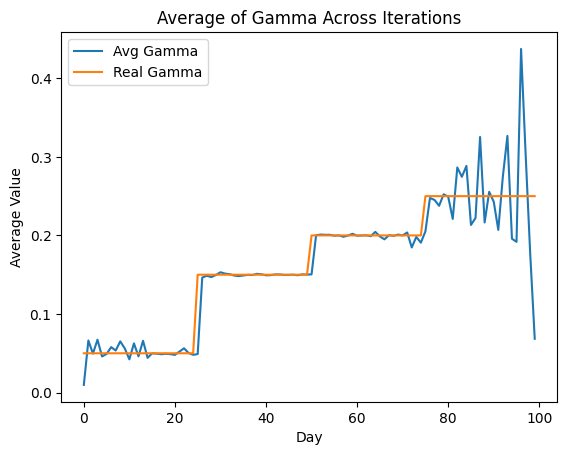

In [ ]:
gamma_arrays = res['gamma']
gamma_stack = np.stack(gamma_arrays)
gamma_mean = np.mean(gamma_stack, axis=0)

plt.plot(gamma_mean, label='Avg Gamma')
plt.plot(gamma_mod_t, label='Real Gamma')
plt.title('Average of Gamma Across Iterations')
plt.xlabel('Day')
plt.ylabel('Average Value')
plt.legend()
plt.show()

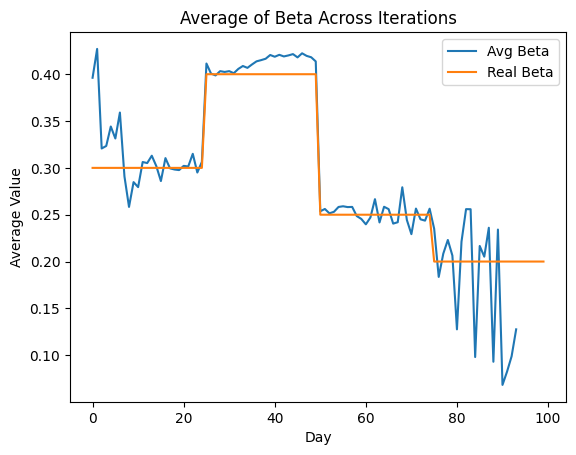

In [ ]:
beta_arrays = res['beta']
beta_stack = np.stack(beta_arrays)
beta_mean = np.mean(beta_stack, axis=0)

plt.plot(beta_mean[1:95], label='Avg Beta')
plt.plot(beta_mod_t, label='Real Beta')
plt.title('Average of Beta Across Iterations')
plt.xlabel('Day')
plt.ylabel('Average Value')
plt.legend()
plt.show()

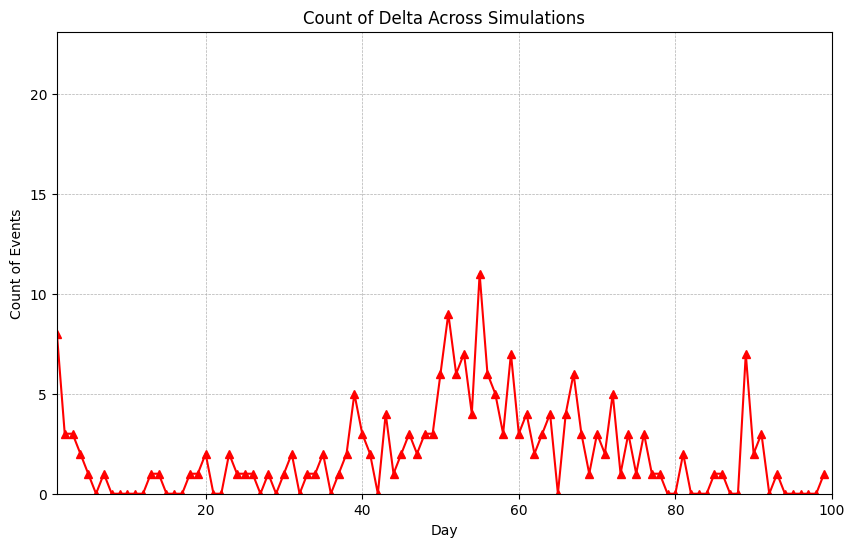

In [ ]:
delta_arrays = res['Delta']
delta_sum = np.sum(np.stack(delta_arrays), axis=0)

plt.figure(figsize=(10, 6))
plt.plot(delta_sum, 'r-^')
plt.title('Count of Delta Across Simulations')
plt.xlabel('Day')
plt.ylabel('Count of Events')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(1, 100)
plt.ylim(0, max(delta_sum[1:100])*2.1)
plt.show()

-----------------------------------------------------------------------

Obtain $\hat{\delta}$ with aggregation

Using the MCMC algorithm, a set of posterior samples {($\delta^{(g)}$
,$b^{(g)}$
,$r^{(g)}$
,$\beta^{(g)}$
,$\gamma^{(g)}$
) : g = 1, ... ,G} is obtained
for inference. Because the main interest lies in detection of change points, we aggregate $\delta^{(1)}$
, ... , $\delta^{(g)}$ to obtain a point estimate $\hat{\delta}$ (or the corresponding $\hat{\eta}$). As the indicator vector $\delta$ is a binary vector with 2T−1 possible values in total, its posterior mean does not imply a partition of the study period and thus is difcult to interpret. Taking the sequential structure of $\delta$ into consideration, we interpret each $\delta^{(g)}$(or the corresponding $\eta^{(g)}$) as a cluster of time points 1, ... , T and obtain $\hat{\delta}$ by solving a clustering aggregation problem as follows.




For each pair of time points $t$ and $t'$, $(1 \leq t < t' \leq T)$ ,we estimate the posterior probability that no change
points exist in the time period {$t + 1$, ... , $t′$
} as :
$$\hat{q}_{tt'} = \frac{1}{G} \sum_{g=1}^{G} I(\eta_{t}^{(g)} = \eta_{t'}^{(g)})$$


Te Bayes estimator $\hat{\delta}$ is then obtained as
$$\hat{\delta} = \arg \min_{\delta} \sum_{1 \leq t < t' \leq T} I(\eta_t = \eta_{t'}) - \hat{q}_{tt'}$$
where $\eta{(t)} = \sum_{u=1}^{t} \delta_{u}$

In [ ]:
def qmat(etas_samples):
    T = etas_samples.shape[1]
    G = etas_samples.shape[0]

    # num_iterations, T = etas_samples.shape
    q_matrix = np.zeros((T, T))

    for t in range(T):
        for t_prime in range(t + 1, T):  # Ensure t < t_prime
            q_matrix[t, t_prime] = np.sum(etas_samples[:, t] == etas_samples[:, t_prime])

    q_matrix /= G

    return q_matrix

In [ ]:
def bayes_estimator(q_hat, T, monte_carlo_deltas):

    def indicator(x):
        return 1 if x else 0

    min_sum = float('inf')
    best_delta = None

    # Iterate over delta values from Monte Carlo simulations
    for delta in monte_carlo_deltas:
        eta_t = np.cumsum(delta)
        current_sum = 0

        for t in range(1, T):
            for t_prime in range(t + 1, T + 1):
                current_sum += abs(indicator(eta_t[t - 1] == eta_t[t_prime - 1]) - q_hat[t - 1, t_prime - 1])

        if current_sum < min_sum:
            min_sum = current_sum
            best_delta = delta

    return best_delta

In [ ]:
def filter_deltas(deltas):
    return [delta for delta in deltas if not all(val == 1 for val in delta)]

In [ ]:
ee = np.array(res['Stage'])
ee = np.array(filter_deltas(ee))
q= qmat(ee)
delta_hat_final = bayes_estimator(q, 100, res['Delta'])

print("Final Delta :", delta_hat_final)
print("Days where the changes happened", np.where(delta_hat_final==1))

Final Delta : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Days where the changes happened (array([ 0, 55]),)


----------------------------------------------------------------------------------------------------------------------

### Adjusted Rand index and Mutual Informatio::
To quantitatively measure the agreement between the true $\delta$ (or $\eta$) and the estimator $\hat{\delta}$ (or $\hat{\eta}$), we transfer the
stage allocation of time points {1, ... , T} to a clustering problem and adopt the adjusted Rand index and the
mutual information as evaluation metrics.

$$
\text{ARI} = \frac{(\text{TP} + \text{TN}) - \{(\text{TP} + \text{FP})(\text{TP} + \text{FN}) + (\text{TN} + \text{FP})(\text{TN} + \text{FN})\}}{1 - \{(\text{TP} + \text{FP})(\text{TP} + \text{FN}) + (\text{TN} + \text{FP})(\text{TN} + \text{FN})\}}
$$

$$
\begin{aligned}
&\text{TP} = \frac{2}{T(T-1)} \sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t = \eta_{t'}, \hat{\eta}_t = \hat{\eta}_{t'}) \\
&\text{FP} = \frac{2}{T(T-1)} \sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t \neq \eta_{t'}, \hat{\eta}_t = \hat{\eta}_{t'}) \\
&\text{FN} = \frac{2}{T(T-1)} \sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t = \eta_{t'}, \hat{\eta}_t \neq \hat{\eta}_{t'}) \\
&\text{TN} = \frac{2}{T(T-1)} \sum_{1 \leq t < t' \leq T} \mathbb{I}(\eta_t \neq \eta_{t'}, \hat{\eta}_t \neq \hat{\eta}_{t'})
\end{aligned}
$$

Te range of ARI is [0, 1], where a larger ARI suggests that $\hat{\delta}$ is more similar to $\delta$ and the maximum possible value is obtained when $\hat{\delta}$ = $\delta$.


In [ ]:
def ARI(delta_hat, delta, T):

    def indicator(condition):
        return 1 if condition else 0

    TP = FP = FN = TN = 0

    for t1, t2 in combinations(range(T), 2):
        true_cluster = delta[t1] == delta[t2]
        predicted_cluster = delta_hat[t1] == delta_hat[t2]

        TP += indicator(true_cluster and predicted_cluster)
        FP += indicator(not true_cluster and predicted_cluster)
        FN += indicator(true_cluster and not predicted_cluster)
        TN += indicator(not true_cluster and not predicted_cluster)


    TP /= (T * (T - 1) / 2)
    FP /= (T * (T - 1) / 2)
    FN /= (T * (T - 1) / 2)
    TN /= (T * (T - 1) / 2)


    value = TP + TN
    expected_value = (TP + FP) * (TP + FN) + (TN + FP) * (TN + FN)

    ARI = (value - expected_value) / (1 - expected_value)

    return ARI

In [ ]:
Delta = np.tile(np.concatenate(([1], np.repeat(0, 24))), 4)
T_max= len(Delta)
ari_score = ARI(delta_hat_final, Delta,T_max)
print(f"Adjusted Rand Index: {ari_score:.4f}")

Adjusted Rand Index: 0.3013


In [ ]:
## ARI of 100 samples
def ARI2(delta_hat, delta, T):
    def indicator(condition):
        return 1 if condition else 0

    TP = FP = FN = TN = 0

    for t1, t2 in combinations(range(T), 2):
        true_cluster = delta[t1] == delta[t2]
        predicted_cluster = delta_hat[t1] == delta_hat[t2]

        TP += indicator(true_cluster and predicted_cluster)
        FP += indicator(not true_cluster and predicted_cluster)
        FN += indicator(true_cluster and not predicted_cluster)
        TN += indicator(not true_cluster and not predicted_cluster)

    TP /= (T * (T - 1) / 2)
    FP /= (T * (T - 1) / 2)
    FN /= (T * (T - 1) / 2)
    TN /= (T * (T - 1) / 2)

    value = TP + TN
    expected_value = (TP + FP) * (TP + FN) + (TN + FP) * (TN + FN)

    ARI = (value - expected_value) / (1 - expected_value)

    return ARI

In [ ]:
def compute_ari_stats(delta_hat_list, delta):
    T = len(delta)
    ari_values = [ARI(delta_hat, delta, T) for delta_hat in delta_hat_list]

    mean_ari = np.mean(ari_values)
    var_ari = np.var(ari_values)

    return mean_ari, var_ari

In [ ]:
def filt(array_list):
    def matches_pattern(arr): #del [1,0,0,....] delta
        return arr[0] == 1 and all(x == 0 for x in arr[1:])
    filtered_list = [array for array in array_list if matches_pattern(array)]

    # Take the last 100
    if len(filtered_list) > 100:
        filtered_list = filtered_list[-100:]
    return filtered_list

In [ ]:
# Filter the list of predicted arrays and select the last 100
filtered_delta_pred_list = filt(np.array(res['Delta']))

# Compute mean and variance of ARI for the filtered list
mean_ari, var_ari = compute_ari_stats(filtered_delta_pred_list, delta_hat_final)
print(f"Mean ARI: {mean_ari}")
print(f"Variance of ARI: {var_ari}")

Mean ARI: 0.6552444630171327
Variance of ARI: 1.232595164407831e-32


### Mutual Informatio:
Mutual Information is defined as:
$$
MI = \sum_{k=1}^{K} \sum_{k'=1}^{K'} \frac{n_{kk'}}{\ T} \log \left( \frac{n_{kk'} \cdot T}{n_{k\cdot} \cdot n_{\cdot k'}} \right)
$$
where
\begin{align*}
K' &= \sum_{t=1}^{T} \delta_t', \\
n_{kk'} &= \sum_{t=1}^{T} I(\eta_t = k, \eta_t' = k'), \\
n_{k \cdot} &= \sum_{t=1}^{T} I(\eta_t = k), \\
n_{\cdot k'} &= \sum_{t=1}^{T} I(\eta_t' = k').
\end{align*}

where the range of MI is:
$$
\left[ 0, \sum_{k=1}^{K} \frac{n_k}{T} \log \left( \frac{T}{n_k} \right) \right]
$$


In [ ]:
def MI (delta_hat, delta, T=T_max):

  eta = np.cumsum(delta)
  k, n_k = np.unique(eta, return_counts=True)

  K_hat = np.sum(delta_hat)
  eta_hat = np.cumsum(delta_hat)
  k_prime, n_k_prime = np.unique(eta_hat, return_counts=True)

  k_indices = np.searchsorted(k, eta)
  k_prime_indices = np.searchsorted(k_prime, eta_hat)

  flat_index = k_indices * len(k_prime) + k_prime_indices
  n_kk_flat = np.bincount(flat_index, minlength=len(k) * len(k_prime))

  # Matrix n_k_kprime
  n_kk = n_kk_flat.reshape(len(k), len(k_prime))

  mi = 0
  for i in range(len(k)):
      for j in range(len(k_prime)):
          if n_kk[i, j] > 0:
              p_kk = n_kk[i, j] / T
              p_k = n_k[i]/T
              p_kp = n_k_prime[j] /T
              mi += p_kk * np.log(p_kk / (p_k * p_kp))

  return mi

In [ ]:
Delta = np.tile(np.concatenate(([1], np.repeat(0, 24))), 4)
T_max= len(Delta)
MI(Delta, delta_hat_final, T_max )

0.5630382078290416

##Real Case Senario - Analysis of Omicron wave in Singapore  

In early 2022, Singapore experienced the onset of the Omicron variant of the COVID-19 pandemic.

To explore the shift points during the Omicron wave, data were gathered daily  on confirmed cases and recoveries in Singapore from January 3 to April 21, 2022.

 During this period, a total of 893,854 confirmed cases and 453 deaths from COVID-19 were recorded over 109 days ( T = 109 ).


With a population size ( N ) of 5,930,134, the daily counts of confirmed and recovered cases are illustrated in Fig. 5a.

To understand the trends in transmission rate (beta_t ) and removal rate ( gamma_t ), apply the naive estimators of the model:

$$
\
\hat{\beta}_t = -\frac{1}{P_{t-1}} \log\left(\frac{\Delta I_t}{S_{t-1}}\right), \quad \hat{\gamma}_t = \frac{\Delta R_t}{I_{t-1}}, \quad t = 1, \ldots, T.
\
$$


The transmission rate was initially very high in the first few days, then stabilized between January 18 and March 19, 2022.
Post-March 19, the transmission rate nearly dropped to zero. The removal rate was consistently low before January 18, 2022. However, from January 18 to March 23, the removal rate increased steadily, followed by a sharp drop and a sudden spike due to delayed reporting of recovery cases between March 24 and April 1, 2022.

In [ ]:
N = 5930134

# Read the .csv file into a DataFrame
df = pd.read_csv('Singapore_new.csv')
print(df.head(5))

df1 = pd.read_csv('Singapore_new.csv')

# Remove the first column
df1 = df1.drop(df.columns[0], axis=1)

# add Recovered+death as a new column
df1['R_obs'] = np.cumsum(df['Recovered'])
df1['D_obs'] = np.cumsum(df['Death'])

# Remove Recovered and death columns
df1 = df1.drop(df.columns[1], axis=1)
df1 = df1.drop(df.columns[2], axis=1)
df1 = df1.drop(df.columns[3], axis=1)

# Rename "confirmed " column
df1.rename(columns={'Active': 'I_obs'}, inplace=True)

# Add new column for susceptible
df1['S_obs'] = N - df1['R_obs'] - df1['I_obs'] - df1['D_obs']
print(df1.head(5))

T_max= len(df1)
print("number of days = " , T_max)

       Date  Confirmed  Recovered  Death  Active
0  3/1/2022        464        364      0    3282
1  4/1/2022        842        274      0    3850
2  5/1/2022        805        423      2    4230
3  6/1/2022       1287        422      1    5094
4  7/1/2022       1251          2      2    6343
   I_obs  R_obs  D_obs    S_obs
0   3282    364      0  5926488
1   3850    638      0  5925646
2   4230   1061      2  5924841
3   5094   1483      3  5923554
4   6343   1485      5  5922301
number of days =  109


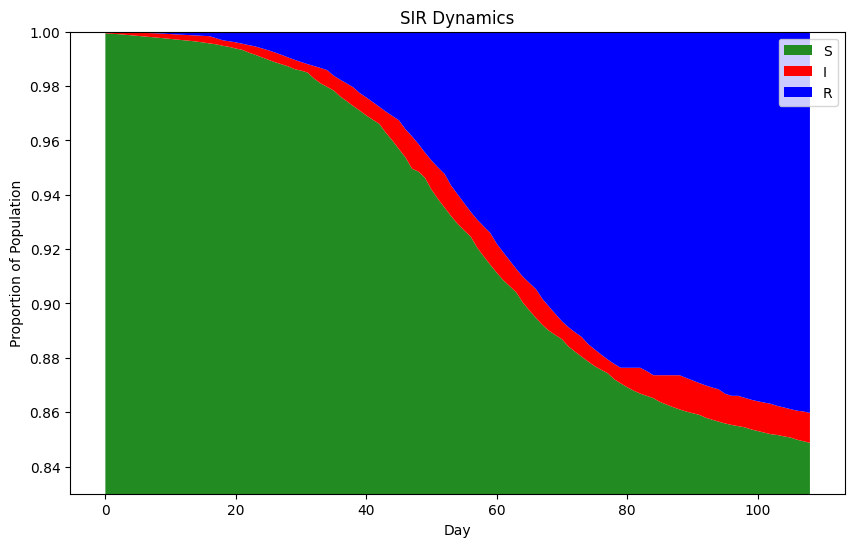

In [ ]:
# Plotting
plotting = True
if plotting == True:
  days = np.arange(T_max)
  plt.figure(figsize=(10, 6))
  plt.stackplot(days, df1['S_obs']/N, df1['I_obs']/N, df1['R_obs']/N, labels=['S', 'I', 'R'], colors=['forestgreen', 'red', 'blue'])
  plt.title('SIR Dynamics')
  plt.xlabel('Day')
  plt.ylabel('Proportion of Population')
  plt.legend(loc='upper right')
  plt.ylim(0.83,1)
  plt.show()

In [ ]:
## Test Initialization Function

# PI_obs = data_atf['PI_obs']
I_obs = df1["I_obs"]
R_obs = df1["R_obs"]
S_obs = df1["S_obs"]
# N_recovery_obs = data_atf['N_recovery_obs']
# N_infect_obs =  data_atf['N_infect_obs']

# Param b
b_shape = 0.1
b_rate = 0.1

# Param r
r_shape = 0.1
r_rate = 0.1

Delta_hat = np.zeros(T_max)
Delta_hat[0] = 1
Stage_hat = np.cumsum(Delta_hat)
K_hat = int(np.max(Stage_hat))
# b_hat, r_hat, beta_hat_init, gamma_hat_init = init_b_r_beta_gamma(b_shape, b_rate, r_shape, r_rate, Delta_hat, Stage_hat, K_hat)
b_hat, r_hat, beta_hat_init, gamma_hat_init = init_b_r_beta_gamma2(b_shape, b_rate, r_shape, r_rate, Delta_hat, Stage_hat, K_hat, S_obs, I_obs, R_obs)

In [ ]:
Delta_hat = np.zeros(T_max)
Delta_hat[0] = 1
# Delta_hat[25] = 1
# Delta_hat[50] = 1
# Delta_hat[75] = 1

res2 = mcmc_run(df1, Delta_hat, p=0.01,samples=10000, T_max=109, burnin=5000, thinning=10)

100%|██████████| 10000/10000 [00:15<00:00, 653.18it/s]


- January 3 to January 27: The transmission rate was high while the removal rate was low, indicating the
outbreak of the Omicron wave and medical resources in Singapore were not ready to cope with the Omicron
variant yet.
- January 28 to February 24: The transmission rate decreased slightly, indicating that people in Singapore
had realized the outbreak of the Omicron wave and begun self-protection activities. In addition, the removal
rate increased to a high level as the Ministry of Health in Singapore begun deploying medical resources to
COVID-19 patients.
- February 25 to March 22: The Omicron wave reached the peak and then passed it due to the sharp decrease
in the transmission rate.
- March 23 to April 1: An abnormal period was detected when recovery cases were not reported for several
days, leading to a sharp drop in the estimated removal rate.
- April 2 to April 21: The Omicron wave became stabilized and under control.

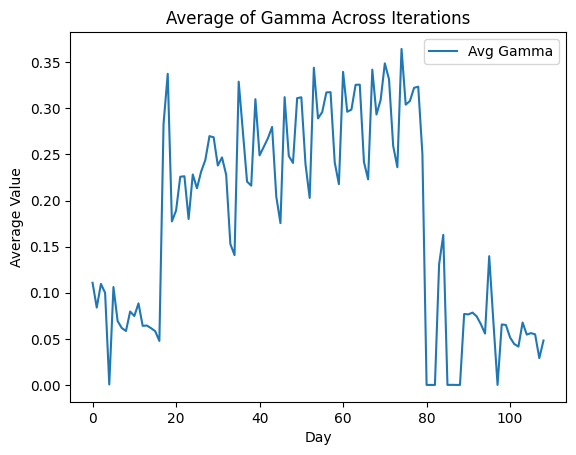

In [ ]:
gamma_arrays = res2['gamma']
gamma_stack = np.stack(gamma_arrays)
gamma_mean = np.mean(gamma_stack, axis=0)

plt.plot(gamma_mean, label='Avg Gamma')
# plt.plot(gamma_mod_t, label='Real Gamma')
plt.title('Average of Gamma Across Iterations')
plt.xlabel('Day') #90-  ]\\?
plt.ylabel('Average Value')
plt.legend()
plt.show()

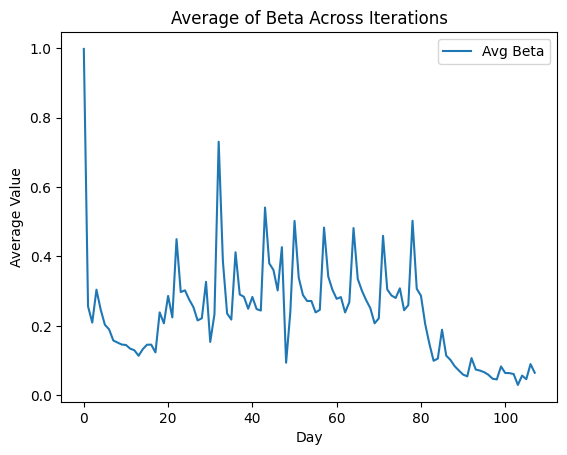

In [ ]:
beta_arrays = res2['beta']
beta_stack = np.stack(beta_arrays)
beta_mean = np.mean(beta_stack, axis=0)

plt.plot(beta_mean[0:108], label='Avg Beta')
# plt.plot(beta_mod_t, label='Real Beta')
plt.title('Average of Beta Across Iterations')
plt.xlabel('Day')
plt.ylabel('Average Value')
plt.legend()
plt.show()

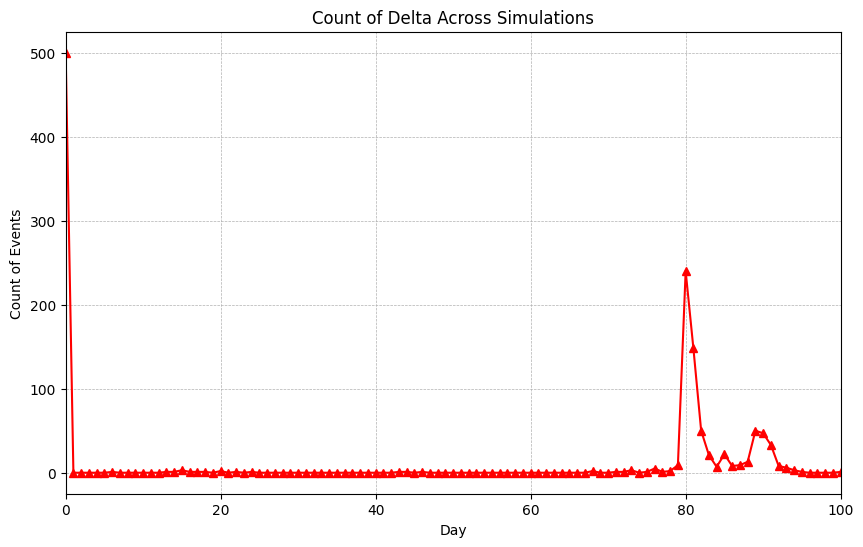

In [ ]:
delta_arrays = res2['Delta']
delta_sum = np.sum(np.stack(delta_arrays), axis=0)

plt.figure(figsize=(10, 6))
plt.plot(delta_sum, 'r-^')
plt.title('Count of Delta Across Simulations')
plt.xlabel('Day')
plt.ylabel('Count of Events')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlim(0, 100)
# plt.ylim(0, max(delta_sum[1:100])*1.1)
plt.show()

In [ ]:
ee = np.array(res['Stage'])
ee = np.array(filter_deltas(ee))
q= qmat(ee)
delta_hat_final = bayes_estimator(q, 100, res['Delta'])
print("Final Delta :", delta_hat_final)
print("Days where the changes happened", np.where(delta_hat_final==1))

Final Delta : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Days where the changes happened (array([ 0, 55]),)


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score([0, 0, 1, 1,0,0,0,1,1,0], [0, 0, 1, 0, 0 ,0 ,1,1,0,0])

0.07079646017699115